In [1]:
import pandas as pd
import psycopg2
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/14/s92q6w094616___lxv11_gm00000gn/T/ipykernel_22863/4145240032.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import dags.config.config as sc

user, host, password = sc.get_postgres_creds()
cols_to_drop = ["id","date_added","uri","track_href","name","artist","type"]
try:
    con = psycopg2.connect(f"dbname='spotify' user='{user}' host='{host}' password='{password}'")
    cur = con.cursor()
    query = "select * from staging"
    cur.execute(query)
    data = cur.fetchall()
    cur.close()
    con.close()
    cols = [desc[0] for desc in cur.description]
except:
    raise "something failed"

In [8]:
df = pd.DataFrame(data,columns=cols).drop(columns=cols_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   country           213 non-null    object 
 1   tempo             213 non-null    float64
 2   duration_ms       213 non-null    int64  
 3   time_signature    213 non-null    int64  
 4   key               213 non-null    int64  
 5   mode              213 non-null    int64  
 6   danceability      213 non-null    float64
 7   energy            213 non-null    float64
 8   loudness          213 non-null    float64
 9   liveness          213 non-null    float64
 10  valence           213 non-null    float64
 11  speechiness       213 non-null    float64
 12  acousticness      213 non-null    float64
 13  instrumentalness  213 non-null    float64
dtypes: float64(9), int64(4), object(1)
memory usage: 23.4+ KB


In [9]:
df.describe()

,tempo,duration_ms,time_signature,key,mode,danceability,energy,loudness,liveness,valence,speechiness,acousticness,instrumentalness
count,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000,213.000000
mean,123.283610,206546.629108,3.887324,5.478873,0.586854,0.667836,0.683545,-5.700911,0.187007,0.523904,0.096866,0.196800,0.012789
std,29.258208,47654.594760,0.430532,3.460801,0.493558,0.143936,0.162161,2.445593,0.140636,0.218497,0.093758,0.208767,0.086123
min,73.929000,87000.000000,1.000000,0.000000,0.000000,0.310000,0.091100,-17.665000,0.023200,0.043200,0.025100,0.000008,0.000000
25%,98.047000,172138.000000,4.000000,2.000000,0.000000,0.555000,0.578000,-6.747000,0.098900,0.350000,0.041100,0.037700,0.000000
50%,120.162000,199440.000000,4.000000,5.000000,1.000000,0.679000,0.687000,-5.360000,0.123000,0.542000,0.058400,0.126000,0.000000
75%,145.816000,234353.000000,4.000000,9.000000,1.000000,0.787000,0.796000,-4.156000,0.236000,0.686000,0.110000,0.295000,0.000021
max,203.759000,368740.000000,4.000000,11.000000,1.000000,0.967000,0.975000,-0.425000,0.856000,0.962000,0.645000,0.959000,0.881000


In [4]:
# Drop nulls
music_data_cleaned = df.dropna().copy()
target = music_data_cleaned["country"]
features = music_data_cleaned.drop(columns=["country"])

# Change country to numerical via label encoding
le = LabelEncoder()
target_encoded  = le.fit_transform(target.to_list())
features["country_encoded"] = target_encoded

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'El Salvador': 0, 'Japan': 1, 'USA': 2}


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]),
 [Text(0.5, 0, 'tempo'),
  Text(1.5, 0, 'duration_ms'),
  Text(2.5, 0, 'time_signature'),
  Text(3.5, 0, 'key'),
  Text(4.5, 0, 'mode'),
  Text(5.5, 0, 'danceability'),
  Text(6.5, 0, 'energy'),
  Text(7.5, 0, 'loudness'),
  Text(8.5, 0, 'liveness'),
  Text(9.5, 0, 'valence'),
  Text(10.5, 0, 'speechiness'),
  Text(11.5, 0, 'acousticness'),
  Text(12.5, 0, 'instrumentalness'),
  Text(13.5, 0, 'country_encoded')])

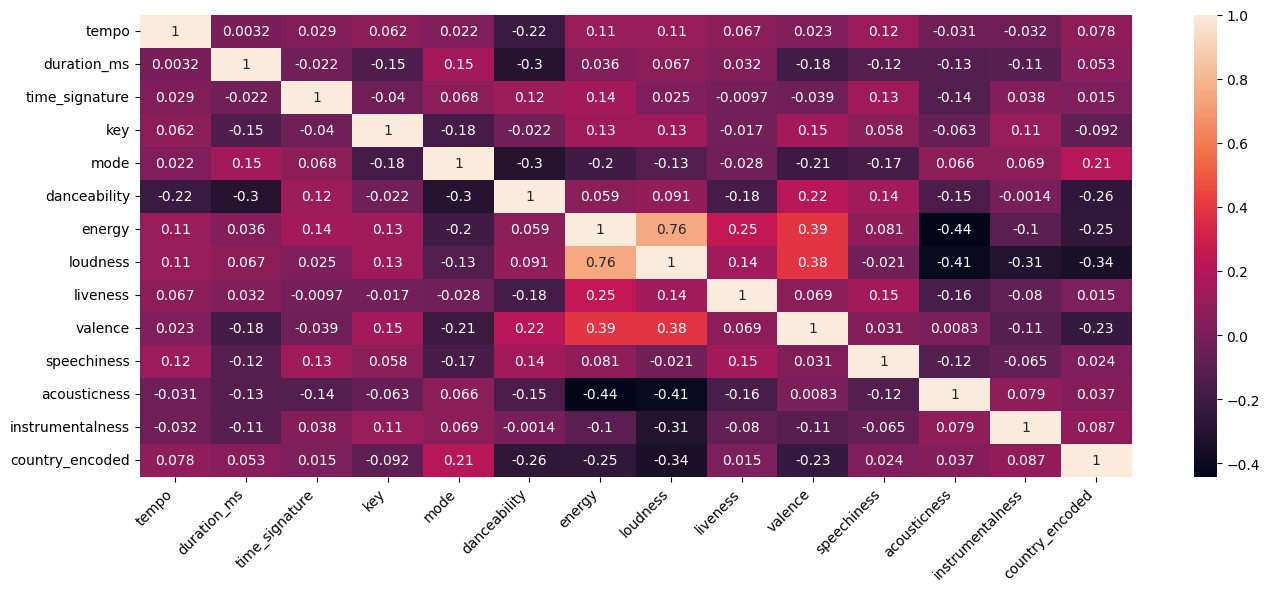

In [5]:
# Create heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(features.corr(), annot=True)
plt.xticks(rotation=45, ha='right')